In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from datetime import datetime
import json

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install imgaug

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib


In [3]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(100)

seq = iaa.Sequential([

    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([

    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

In [4]:
data = np.load('./data_128x128_RGB.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 
del data

In [5]:
from sklearn.model_selection import train_test_split

ix, = np.where(labels_[1,:]>45)

images_c = images_[ix]
labels_c = labels_[1,:][ix]
pgcIDs_c = labels_[0,:][ix]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train_RGB = np.concatenate((images_train, images_test[notUnique]))
labels_train_RGB  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train_RGB = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test_RGB = images_test[Unique]
labels_test_RGB = labels_test[Unique]
pgcIDs_test_RGB = pgcIDs_test[Unique]

del images_
del labels_

del images_c
del labels_c
del pgcIDs_c

In [6]:
data = np.load('./data_128x128_g.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 
del data

pgcIDs_ = labels_[0,:]
labels_ = labels_[1,:]

inTrain = np.isin(pgcIDs_, pgcIDs_train_RGB)
inTest = np.isin(pgcIDs_, pgcIDs_test_RGB)

images_train_gray = images_[inTrain]
labels_train_gray = labels_[inTrain]
pgcIDs_train_gray = pgcIDs_[inTrain]

images_test_gray = images_[inTest]
labels_test_gray = labels_[inTest]
pgcIDs_test_gray = pgcIDs_[inTest]


del pgcIDs_
del labels_
del images_

In [7]:
data = np.load('./data_128x128_r.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 
del data

pgcIDs_ = labels_[0,:]
labels_ = labels_[1,:]

inTrain = np.isin(pgcIDs_, pgcIDs_train_RGB)
inTest = np.isin(pgcIDs_, pgcIDs_test_RGB)

images_train_gray = np.concatenate((images_train_gray, images_[inTrain]))
labels_train_gray = np.concatenate((labels_train_gray, labels_[inTrain]))
pgcIDs_train_gray = np.concatenate((pgcIDs_train_gray, pgcIDs_[inTrain]))

images_test_gray = np.concatenate((images_test_gray, images_[inTest]))
labels_test_gray = np.concatenate((labels_test_gray, labels_[inTest]))
pgcIDs_test_gray = np.concatenate((pgcIDs_test_gray, pgcIDs_[inTest]))


del pgcIDs_
del labels_
del images_

In [8]:
data = np.load('./data_128x128_i.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 
del data

pgcIDs_ = labels_[0,:]
labels_ = labels_[1,:]

inTrain = np.isin(pgcIDs_, pgcIDs_train_RGB)
inTest = np.isin(pgcIDs_, pgcIDs_test_RGB)

images_train_gray = np.concatenate((images_train_gray, images_[inTrain]))
labels_train_gray = np.concatenate((labels_train_gray, labels_[inTrain]))
pgcIDs_train_gray = np.concatenate((pgcIDs_train_gray, pgcIDs_[inTrain]))

images_test_gray = np.concatenate((images_test_gray, images_[inTest]))
labels_test_gray = np.concatenate((labels_test_gray, labels_[inTest]))
pgcIDs_test_gray = np.concatenate((pgcIDs_test_gray, pgcIDs_[inTest]))

del pgcIDs_
del labels_
del images_

In [9]:
N_testGray = len(pgcIDs_test_gray)
N_trainGray = len(pgcIDs_train_gray)

N_testGray, N_trainGray

(3420, 129024)

In [12]:
indx = np.arange(N_testGray)
indx = esn_shuffle(indx, seed=0)

images_test_gray = images_test_gray[indx]
labels_test_gray = labels_test_gray[indx]
pgcIDs_test_gray = pgcIDs_test_gray[indx]

In [13]:
indx = np.arange(N_trainGray)
indx = esn_shuffle(indx, seed=100)

images_train_gray = images_train_gray[indx]
labels_train_gray = labels_train_gray[indx]
pgcIDs_train_gray = pgcIDs_train_gray[indx]

In [14]:
np.savez_compressed('./Gray_128x128_train_000.npz', 
                    images=images_train_gray, 
                    labels=labels_train_gray, 
                    pgcIDs=pgcIDs_train_gray)


In [15]:
np.savez_compressed('./Gray_128x128_test_000.npz', 
                    images=images_test_gray, 
                    labels=labels_test_gray, 
                    pgcIDs=pgcIDs_test_gray)

In [16]:
np.savez_compressed('./RGB_128x128_train_000.npz', 
                    images=images_train_RGB, 
                    labels=labels_train_RGB, 
                    pgcIDs=pgcIDs_train_RGB)


In [17]:
np.savez_compressed('./RGB_128x128_test_000.npz', 
                    images=images_test_RGB, 
                    labels=labels_test_RGB, 
                    pgcIDs=pgcIDs_test_RGB)

### Run this part separately .....

In [11]:
def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [10]:
data = np.load('./Gray_128x128_train_000.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
pgcIDs_ = data['pgcIDs']
data.close() 
del data

In [11]:
images_.shape, pgcIDs_.shape, labels_.shape

((43008, 128, 128, 3), (43008,), (43008,))

In [6]:
N_trainRGB = 43008
N_testRGB = 1140

N_trainGray = 129024
N_testGray = 3420

In [12]:
import gc

t1 =  datetime.now()

for i in range(1):
    
    
    data = np.load('./Gray_128x128_train_000.npz')
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    pgcIDs_ = data['pgcIDs']
    data.close() 
    del data
    
    # Gray
    N = len(labels_)
    indx = np.arange(N)
    indx = esn_shuffle(indx, seed=i+10)
    images_aug = seqGray(images=images_[indx][:N_trainRGB,:,:,:])
    labels_aug = labels_[indx][:N_trainRGB]
    pgcIDs_aug = pgcIDs_[indx][:N_trainRGB]
    
    del images_
    gc.collect()
    
    
    n = len(images_aug)
    p = int(n/2)
    images_aug[:p] = 255 - images_aug[:p]
    indx = np.arange(n)
    indx = esn_shuffle(indx, seed=i+100)
    images_aug = images_aug[indx]
    labels_aug = labels_aug[indx]
    pgcIDs_aug = pgcIDs_aug[indx]

    t2 =  datetime.now()
    print("Execution time: ", i, t2-t1)
    t1 =  datetime.now()

    np.savez_compressed('./Gray_128x128_train_aug_'+str(i)+'.npz', 
                        images=images_aug, 
                        labels=labels_aug, 
                        pgcIDs=pgcIDs_aug)
    print('save #', i)
    t2 =  datetime.now()
    print("Saving time: ", i, t2-t1)
    
    
#     del images_aug
    gc.collect()

Execution time:  0 0:01:05.189924
save # 0
Saving time:  0 0:02:13.656239


In [8]:
# t1 =  datetime.now()

# for i in range(1):
    
    
#     data = np.load('./RGB_128x128_train_000.npz')
#     images_ = data['images'].astype(np.uint8)
#     labels_ = data['labels'] 
#     pgcIDs_ = data['pgcIDs']
#     data.close() 
#     del data
    
#     # RGB
#     images_aug = seq(images=images_) 
#     labels_aug = labels_
#     pgcIDs_aug = pgcIDs_

    
#     del images_
#     gc.collect()
    
#     t2 =  datetime.now()
#     print("Execution time: ", i, t2-t1)

#     np.savez_compressed('./RGB_128x128_train_aug_'+str(i)+'.npz', 
#                         images=images_aug, 
#                         labels=labels_aug, 
#                         pgcIDs=pgcIDs_aug)
#     print('save #', i)
    
#     del images_aug
#     gc.collect()

In [20]:
data = np.load('./RGB_128x128_train_aug_1.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
pgcIDs_ = data['pgcIDs']
data.close() 
del data

In [21]:
images_.shape, pgcIDs_.shape, labels_.shape

((43008, 128, 128, 3), (43008,), (43008,))

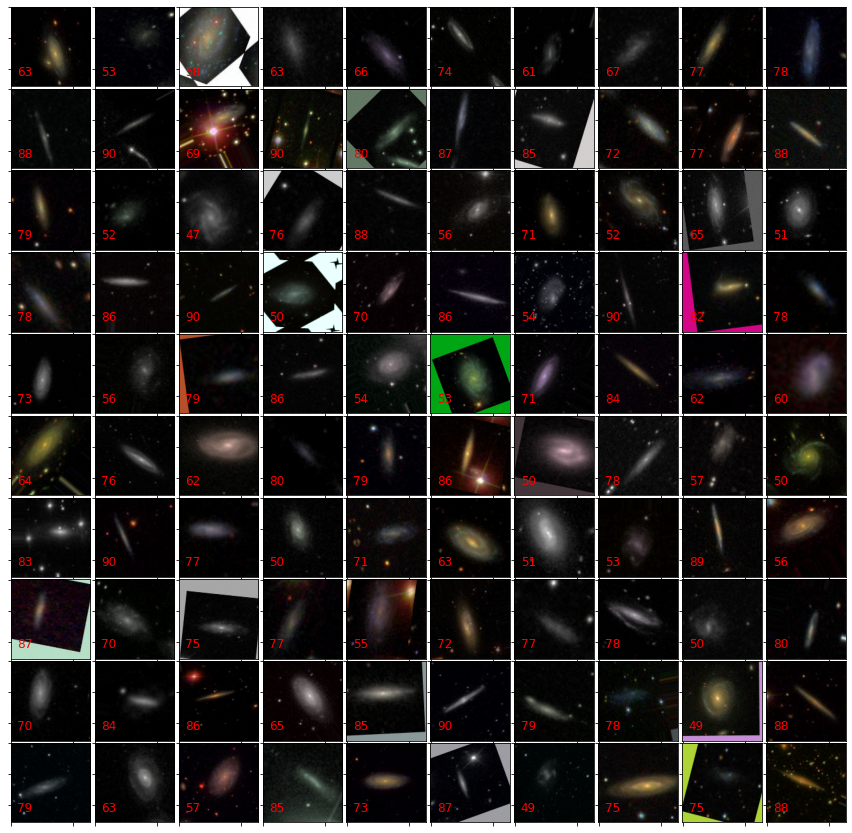

In [22]:
n = 10
m = 10

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
for i in range(n):
    for j in range(m):

        ax = axes[i][j]
        ax.imshow(images_[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.text(10, 110, labels_[t], color='red', fontsize=12)

        t+=1
  
plt.subplots_adjust(hspace=0.03, wspace=0.03)